In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/main/youtube_search.csv"

df = pd.read_csv(url, encoding='latin1')

df.head()


,video_id,link,title,published_at_utc,published_date_wib,published_time_wib,channel_id,channel_title,channel_subscribers,view_count,like_count,comment_count,is_short
0,5VKd5a3j4Lw,https://www.youtube.com/watch?v=5VKd5a3j4Lw,2 Driver Ojek Online Tewas Dilindas Mobil Brim...,2025-08-28T16:56:47Z,8/28/2025,23:56:47,UC9OrydCv7MP6ERljaSPvkzA,JURNAL KUHP,5610,538,6.0,1.0,False
1,Nqj1_RRht7I,https://www.youtube.com/watch?v=Nqj1_RRht7I,viral ojol di lindas mobil brimob #shortvideo ...,2025-08-28T16:55:43Z,8/28/2025,23:55:43,UC2Pe0VX1AlkGAGRflfCogeg,Nirfana agustina Arifin,48,4,1.0,0.0,False
2,mHwZjVZKRRI,https://www.youtube.com/watch?v=mHwZjVZKRRI,Aparat sengaja melindas driver ojol #demo #dem...,2025-08-28T16:52:15Z,8/28/2025,23:52:15,UCCTQUmfEQJ4xyckGzxAhLsg,info padalarang,1640,486,8.0,0.0,True
3,uW4RKYFLAZ8,https://www.youtube.com/watch?v=uW4RKYFLAZ8,waduh gimana ceritanya gojek tertabrak #berita...,2025-08-28T16:50:14Z,8/28/2025,23:50:14,UCTBCkocxIT0TKKq6k4wqWSQ,Pak guru candra,1270,108,1.0,0.0,False
4,nUu6-ONx53M,https://www.youtube.com/watch?v=nUu6-ONx53M,#acab #1312 #allcoparebastard #cops #polisi #p...,2025-08-28T16:48:57Z,8/28/2025,23:48:57,UCxnUtjH7CmOWe76-Zv162_Q,HSfact.,28,400,1.0,0.0,True


In [ ]:
import pandas as pd
import re

url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/main/youtube_search.csv"
df = pd.read_csv(url, encoding="latin1")

df["clean_title"] = df["title"].astype(str).str.lower()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_title"] = df["clean_title"].apply(clean_text)

df = df.drop_duplicates(subset="clean_title")
df = df.dropna(subset=["clean_title"])
df = df[df["clean_title"].str.len() > 0]

print("Jumlah data setelah preprocessing:", len(df))
df[["title", "clean_title"]].head()

Jumlah data setelah preprocessing: 912


,title,clean_title
0,2 Driver Ojek Online Tewas Dilindas Mobil Brim...,driver ojek online tewas dilindas mobil brimob...
1,viral ojol di lindas mobil brimob #shortvideo ...,viral ojol di lindas mobil brimob shortvideo f...
2,Aparat sengaja melindas driver ojol #demo #dem...,aparat sengaja melindas driver ojol demo demoh...
3,waduh gimana ceritanya gojek tertabrak #berita...,waduh gimana ceritanya gojek tertabrak beritat...
4,#acab #1312 #allcoparebastard #cops #polisi #p...,acab allcoparebastard cops polisi polisiindone...


In [ ]:
!pip -q install transformers accelerate

import pandas as pd
from transformers import pipeline

pd.set_option("display.max_colwidth", None)

# Data
url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/main/youtube_search.csv"
df = pd.read_csv(url, encoding="latin1")
texts = df["title"].astype(str).fillna("").tolist()

# Model
model_ids = [
    "Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis",
    "w11wo/indonesian-roberta-base-sentiment-classifier",
    "taufiqdp/indonesian-sentiment"
]

preds = []
for mid in model_ids:
    clf = pipeline("text-classification", model=mid, tokenizer=mid, truncation=True)
    preds.append(clf(texts, batch_size=32))

out = df.copy()

out["m1_label_raw"] = [p["label"] for p in preds[0]]
out["m1_score"]     = [p["score"] for p in preds[0]]
out["m2_label_raw"] = [p["label"] for p in preds[1]]
out["m2_score"]     = [p["score"] for p in preds[1]]
out["m3_label_raw"] = [p["label"] for p in preds[2]]
out["m3_score"]     = [p["score"] for p in preds[2]]

def norm_label(s):
    s = str(s).strip().lower()
    mapping = {
        "neutral": "neutral",
        "netral": "neutral",
        "positive": "positive",
        "positif": "positive",
        "negative": "negative",
        "negatif": "negative"
    }
    if s not in mapping:
        if "neu" in s: return "neutral"
        if "pos" in s: return "positive"
        if "neg" in s: return "negative"
    return mapping.get(s, s)

out["m1_label"] = out["m1_label_raw"].map(norm_label)
out["m2_label"] = out["m2_label_raw"].map(norm_label)
out["m3_label"] = out["m3_label_raw"].map(norm_label)

mask_diff = ~(
    (out["m1_label"] == out["m2_label"]) &
    (out["m1_label"] == out["m3_label"])
)

df_berbeda = out.loc[mask_diff, [
    "title",
    "m1_label","m1_score",
    "m2_label","m2_score",
    "m3_label","m3_score"
]].reset_index(drop=True)

print("Total rows:", len(out), "| Rows with disagreement:", len(df_berbeda))
df_berbeda

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Total rows: 927 | Rows with disagreement: 470


,title,m1_label,m1_score,m2_label,m2_score,m3_label,m3_score
0,viral ojol di lindas mobil brimob #shortvideo #fyp #viral #gojek #demodpr #brimob #beritaterkini,neutral,0.994294,negative,0.517928,neutral,0.983681
1,Aparat sengaja melindas driver ojol #demo #demohariini #driverojol #grab #gojek #indiver #viral #fyp,neutral,0.994877,negative,0.998091,neutral,0.979000
2,#acab #1312 #allcoparebastard #cops #polisi #polisiindonesia #brimob #oknumpolisi #gojek #shorts,neutral,0.988619,negative,0.998107,neutral,0.984110
3,Part 2 Hari ke 3 Terapi akun gojek #viral #shorts #fyp #ojol #gojek,neutral,0.995989,negative,0.606960,neutral,0.980913
4,#demo27agustus #gojek #grab #ojol #fypage? #fypyoutube #masukberanda #viral #viralkannadashort,neutral,0.996526,negative,0.982717,neutral,0.971188
...,...,...,...,...,...,...,...
465,BRIMOB TABRAK DRIVER OJOL GOJEK DI LINDAS BARACKUDA PUKUL 19.40 WIB TKP LAMER BENHIL,neutral,0.997360,negative,0.986954,neutral,0.982261
466,aksi keja kejaran polisi habis melindas driver ojol,negative,0.907939,negative,0.635732,neutral,0.982581
467,A Gojek Driver Died After A Police Tactical Vehicle Ran Over Him,negative,0.514296,neutral,0.957368,neutral,0.982405
468,"inalillahi wainnailaihi rojiun, rip driver gojek??",negative,0.993238,neutral,0.588502,neutral,0.966497


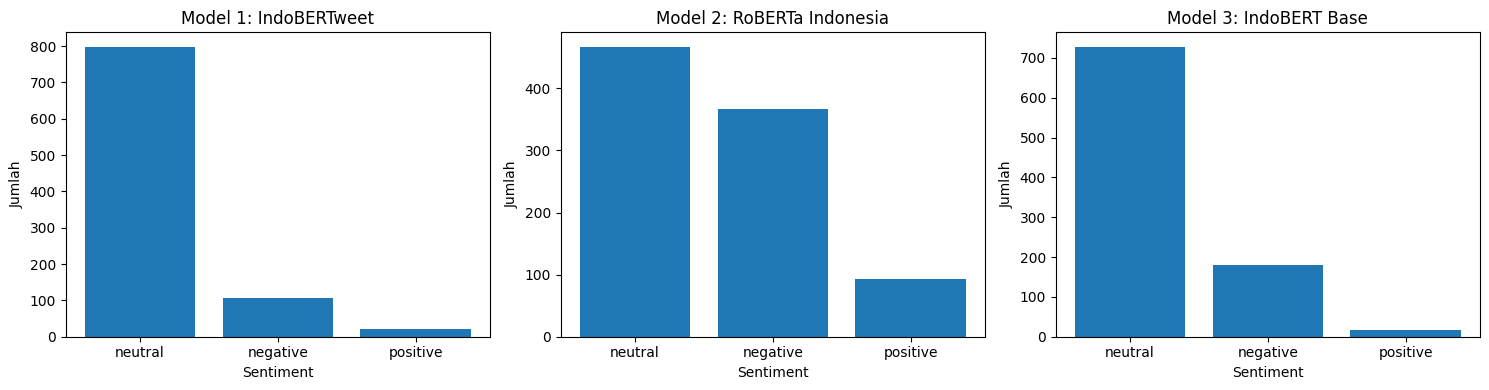

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

counts_m1 = out["m1_label"].value_counts()
counts_m2 = out["m2_label"].value_counts()
counts_m3 = out["m3_label"].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(counts_m1.index, counts_m1.values)
axes[0].set_title("Model 1: IndoBERTweet")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Jumlah")

axes[1].bar(counts_m2.index, counts_m2.values)
axes[1].set_title("Model 2: RoBERTa Indonesia")
axes[1].set_xlabel("Sentiment")
axes[1].set_ylabel("Jumlah")

axes[2].bar(counts_m3.index, counts_m3.values)
axes[2].set_title("Model 3: IndoBERT Base")
axes[2].set_xlabel("Sentiment")
axes[2].set_ylabel("Jumlah")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

cols_to_drop = [c for c in out.columns if c.startswith("m2_")]
out = out.drop(columns=cols_to_drop, errors="ignore")

mask_pos = (out["m1_label"] == "positive") & (out["m3_label"] == "positive")
df_keduanya_positif = out.loc[mask_pos, [
    "title",
    "m1_label","m1_score",
    "m3_label","m3_score"
]].reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
df_keduanya_positif

Jumlah baris dengan dua model positif: 8


,title,m1_label,m1_score,m3_label,m3_score
0,Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral,positive,0.960438,positive,0.901260
1,Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral,positive,0.960438,positive,0.901260
2,Aisar Khaledd Sudah Jadi Sahabat Ojol Sejak Dulu Karna Dia Sering Berbagi ke Oj di Indo dan Malay,positive,0.985095,positive,0.799475
3,"Respect!!! sama ribuan abang"" ojol yg mengantarkan Alm. Affan Kurniawan",positive,0.996202,positive,0.993710
4,OJOL UNTUNG BANYAK,positive,0.702414,positive,0.994967
5,SURGA DI TEMPATMU AFFAN KURNIAWAN,positive,0.558916,positive,0.852983
6,Bapak TNI Selalu Untuk Rakyat #demodpr #ojol,positive,0.900748,positive,0.856949
7,Nano Banana FREE FOR A YEAR with Higgsfield AI!!,positive,0.960116,positive,0.846279


In [ ]:
rows_to_drop = [2, 4, 7]
df_keduanya_positif = df_keduanya_positif.drop(rows_to_drop, errors="ignore").reset_index(drop=True)

print("Jumlah baris setelah dihapus:", len(df_keduanya_positif))
pd.set_option("display.max_colwidth", None)
df_keduanya_positif


Jumlah baris setelah dihapus: 5


,title,m1_label,m1_score,m3_label,m3_score
0,Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral,positive,0.960438,positive,0.901260
1,Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral,positive,0.960438,positive,0.901260
2,"Respect!!! sama ribuan abang"" ojol yg mengantarkan Alm. Affan Kurniawan",positive,0.996202,positive,0.993710
3,SURGA DI TEMPATMU AFFAN KURNIAWAN,positive,0.558916,positive,0.852983
4,Bapak TNI Selalu Untuk Rakyat #demodpr #ojol,positive,0.900748,positive,0.856949


In [ ]:
import pandas as pd

df_model1 = out[[
    "video_id", "link", "title",
    "published_date_wib", "channel_title",
    "view_count", "like_count", "comment_count",
    "m1_label", "m1_score"
]].rename(columns={
    "m1_label": "sentiment_label",
    "m1_score": "sentiment_score"
}).reset_index(drop=True)

print("Jumlah data:", len(df_model1))
pd.set_option("display.max_colwidth", None)
df_model1.head(20)

Jumlah data: 927


,video_id,link,title,published_date_wib,channel_title,view_count,like_count,comment_count,sentiment_label,sentiment_score
0,5VKd5a3j4Lw,https://www.youtube.com/watch?v=5VKd5a3j4Lw,"2 Driver Ojek Online Tewas Dilindas Mobil Brimob, Saat Aksi Demo DPR Hari ini",8/28/2025,JURNAL KUHP,538,6.0,1.0,neutral,0.987447
1,Nqj1_RRht7I,https://www.youtube.com/watch?v=Nqj1_RRht7I,viral ojol di lindas mobil brimob #shortvideo #fyp #viral #gojek #demodpr #brimob #beritaterkini,8/28/2025,Nirfana agustina Arifin,4,1.0,0.0,neutral,0.994294
2,mHwZjVZKRRI,https://www.youtube.com/watch?v=mHwZjVZKRRI,Aparat sengaja melindas driver ojol #demo #demohariini #driverojol #grab #gojek #indiver #viral #fyp,8/28/2025,info padalarang,486,8.0,0.0,neutral,0.994877
3,uW4RKYFLAZ8,https://www.youtube.com/watch?v=uW4RKYFLAZ8,waduh gimana ceritanya gojek tertabrak #beritaterkini,8/28/2025,Pak guru candra,108,1.0,0.0,negative,0.895854
4,nUu6-ONx53M,https://www.youtube.com/watch?v=nUu6-ONx53M,#acab #1312 #allcoparebastard #cops #polisi #polisiindonesia #brimob #oknumpolisi #gojek #shorts,8/28/2025,HSfact.,400,1.0,0.0,neutral,0.988619
5,P1yardeBkDs,https://www.youtube.com/watch?v=P1yardeBkDs,Go-Jek di LINDES MOBIL DINAS,8/28/2025,Musisi jalan chanel,7,1.0,0.0,neutral,0.811861
6,ZwMO0ZEDjzw,https://www.youtube.com/watch?v=ZwMO0ZEDjzw,Part 2 Hari ke 3 Terapi akun gojek #viral #shorts #fyp #ojol #gojek,8/28/2025,DriverSenengSambat,856,4.0,0.0,neutral,0.995989
7,e7RvFDwPWBI,https://www.youtube.com/watch?v=e7RvFDwPWBI,#demo27agustus #gojek #grab #ojol #fypage? #fypyoutube #masukberanda #viral #viralkannadashort,8/28/2025,Gendhis maniss,3,1.0,0.0,neutral,0.996526
8,VAtIFWRVWEI,https://www.youtube.com/watch?v=VAtIFWRVWEI,demo masa ke dpr gojek di lindas polisii,8/28/2025,SKF FOREVER,0,0.0,0.0,neutral,0.915362
9,Q3vRQuJCLd4,https://www.youtube.com/watch?v=Q3vRQuJCLd4,edisi ngojek agustus belum gopek belum pulang?? #gojek #gojekdriver #shorts #ojol,8/28/2025,Pemburu orderan,901,11.0,4.0,neutral,0.951302


# Topic Modeling

In [ ]:
!pip -q install bertopic sentence-transformers umap-learn hdbscan Sastrawi

import re, pandas as pd, numpy as np
from datetime import datetime
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", None)

if "df_model1" in globals():
    df_src = df_model1.copy()
else:
    url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/main/youtube_search.csv"
    df_src = pd.read_csv(url, encoding="latin1")[["video_id","link","title","published_date_wib","channel_title","view_count","like_count","comment_count"]]

def basic_clean(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^\w#\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_src["title_clean"] = df_src["title"].astype(str).apply(basic_clean)
df_src = df_src[df_src["title_clean"].str.len() > 0].reset_index(drop=True)

stop_factory = StopWordRemoverFactory()
stop_id = set(stop_factory.get_stop_words())
stop_extra = {
    "video","channel","subscribe","shorts","shortvideo","fyp","viral","latest",
    "hari","ini","kamu","kita","aja","dong","nih","banget","yang","untuk","dari","dan",
    "di","ke","ada","akan","itu","ini","dengan","para"
}
stopwords = list(stop_id.union(stop_extra))

vectorizer_model = CountVectorizer(
    ngram_range=(1,2),
    stop_words=stopwords,
    token_pattern=r"(?u)\b[^\d\W]+\b",
    min_df=2
)

embedding_model = SentenceTransformer("indolem/indobertweet-base-uncased")

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="indonesian",
    vectorizer_model=vectorizer_model,
    min_topic_size=8,
    nr_topics="auto",
    calculate_probabilities=True,
    verbose=False
)

texts = df_src["title_clean"].tolist()
topics, probs = topic_model.fit_transform(texts)

df_topics = df_src.copy()
df_topics["topic"] = topics
df_topics["topic_prob"] = [float(np.max(p)) if isinstance(p, (list, np.ndarray)) else (p if p is not None else np.nan) for p in probs]

topic_info = topic_model.get_topic_info()
top_terms = {
    t: [w for w,_ in topic_model.get_topic(t)[:10]]
    for t in topic_info["Topic"].tolist() if t != -1
}

print("Jumlah dokumen:", len(df_topics))
print("Jumlah topik (tanpa -1):", (topic_info["Topic"] != -1).sum())
display(topic_info.head(15))

for t in topic_info["Topic"].head(5):
    if t == -1:
        continue
    print(f"\nTOPIK {t} | kata kunci: {', '.join(top_terms.get(t, [])[:8])}")
    sampel = df_topics[df_topics["topic"] == t].head(3)[["title"]].to_string(index=False)
    print(sampel)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Jumlah dokumen: 927
Jumlah topik (tanpa -1): 7


,Topic,Count,Name,Representation,Representative_Docs
0,-1,353,-1_ojol_gojek_brimob_demo,"[ojol, gojek, brimob, demo, driver, polisi, grab, mobil, affan, driver ojol]","[detik detik tertabraknya driver ojol oleh brimob part 2 #ojol #grab #gojek #fyp #viral #kepogua, mobil brimob lindas ojol #trending #beritaterkini #polisi #brimob #ojol #gojek #grab #indriver #dpr, detik detik tertabraknya driver ojol oleh brimob #ojol #grab #gojek #fyp #viral #demo2025]"
1,0,223,0_brimob_rantis_ojol_dilindas,"[brimob, rantis, ojol, dilindas, rantis brimob, affan, driver, tewas, mobil, driver ojol]","[ojol dilindas rantis brimob, sosok affan kurniawan driver ojol tewas dilindas mobil brimob saat demo tulang punggung keluarga, affan driver ojol yang tewas dilindas rantis brimob tulang punggung keluarga]"
2,1,222,1_gojek_ojol_demo_brimob,"[gojek, ojol, demo, brimob, dpr, ojol gojek, polisi, grab, demodpr, trending]","[ojol kelindes mobil brimob #ojol #brimob #demo #dpr #demodpr #gojek #ojek #trending #shorts #viral, ojol solid #shorts #infomation #viral #shortvideo #films #corefilms#ojol #gojek, hati hati provokasi #liongbie #konsultanspiritual #demo #dpr #indonesia #fbpro #ojol #gojek #fyp]"
3,2,56,2_affan_affan kurniawan_kurniawan_goto,"[affan, affan kurniawan, kurniawan, goto, turut, driver, gojek, ojol, atas, mitra]","[pt goto gojek tokopedia tbk ucapankan duka cita mitra driver gojek affan kurniawan meninggal, goto pastikan almarhum affan kurniawan mitra driver gojek akan diberi santunan ntvnewsid, surga di tempatmu affan kurniawan]"
4,3,29,3_ojol rantis_ojol_brimob_usai,"[ojol rantis, ojol, brimob, usai, rantis, ojol polisi, mobil, rantis brimob, anggota brimob, driver]","[kapolri minta maaf driver ojol tew4s dilind4s rantis brimob #artist #beritaterkini, terungkap 7 brimob diperiksa usai driver ojol tew4s terlind4s rantis #brimob #driverojol #viral, 7 anggota brimob diperiksa usai rantis tew4sk4n driver ojol fakta terbaru bikin geger #brimob]"
5,4,15,4_prabowo_insiden_janji_kematian,"[prabowo, insiden, janji, kematian, maaf, tegas insiden, petugas, respons prabowo, minta maaf, respons]","[momen perwakilan brimob minta maaf seusai insiden rantis lindas ojol janji bakal tanggung jawab, prabowo arah siasatan telus janji tindakan tegas insiden kematian pemandu gojek, prabowo arah siasatan telus janji tindakan tegas insiden kematian pemandu gojek]"
6,5,15,5_bivak_karet bivak_karet_tpu,"[bivak, karet bivak, karet, tpu, tpu karet, peristirahatan, affan, terakhir, affan kurniawan, jenazah]","[suasana lokasi pemakaman driver ojol affan kurniawan di tpu karet bivak, ribuan ojol antarkan jenazah affan kurniawan ke tpu karet bivak jakarta pusat, penghormatan terakhir untuk affan ribuan ojol antar jenazah affan kurniawan ke tpu karet bivak]"
7,6,14,6_affankurniawan_affankurniawan ojol_affan_pasha ungu,"[affankurniawan, affankurniawan ojol, affan, pasha ungu, ungu, pasha, aisar, ojol, melayat, ungu melayat]","[affan kurniawan diantar kepemakaman #affankurniawan #ojol #gojek #btstrans7 #beritaterkini, pasha ungu melayat ke rumah affan kurniawan driver ojol k0rban d3m0 #affankurniawan #dpr #shorts, pasha ungu melayat ke ruma duka affan ojol #affankurniawan #ojol #fyp #trend #brimob]"



TOPIK 0 | kata kunci: brimob, rantis, ojol, dilindas, rantis brimob, affan, driver, tewas
                                       title
                Go-Jek di LINDES MOBIL DINAS
    demo masa ke dpr gojek di lindas polisii
Kata Gojek Ojol Dilindas Mobil Rantis Brimob

TOPIK 1 | kata kunci: gojek, ojol, demo, brimob, dpr, ojol gojek, polisi, grab
                                                                                         title
                           Part 2 Hari ke 3 Terapi akun gojek #viral #shorts #fyp #ojol #gojek
#demo27agustus #gojek #grab #ojol #fypage? #fypyoutube #masukberanda #viral #viralkannadashort
             edisi ngojek agustus belum gopek belum pulang?? #gojek #gojekdriver #shorts #ojol

TOPIK 2 | kata kunci: affan, affan kurniawan, kurniawan, goto, turut, driver, gojek, ojol
                                                                                         title
GoTo Pastikan Affan Kurniawa Mitra Ojek Online, dan Akan Beri Bantuan Penuh ke Kelu

In [ ]:
pd.set_option("display.max_colwidth", None)

for topic_num in topic_info["Topic"]:
    if topic_num == -1:
        continue
    print(f"\nTOPIK {topic_num} | {', '.join([w for w,_ in topic_model.get_topic(topic_num)[:10]])}")
    sample_titles = df_topics[df_topics["topic"] == topic_num]["title"].head(15)
    for i, title in enumerate(sample_titles, start=1):
        print(f"{i}. {title}")


TOPIK 0 | brimob, rantis, ojol, dilindas, rantis brimob, affan, driver, tewas, mobil, driver ojol
1. Go-Jek di LINDES MOBIL DINAS
2. demo masa ke dpr gojek di lindas polisii
3. Kata Gojek Ojol Dilindas Mobil Rantis Brimob
4. pendemo dengan seragam gojek terlindas mobil brimob
5. Driver gojek tergilas mobil rantis brimob
6. gojek dilindas mobil brimob
7. Driver GO-JEK di L1nd@s Mobil brimob! || Driver gojek & masa Bersatu kejar pelaku sampai Kantor ??
8. Gojek atau Ojol dilindas mobil baracuda
9. suluk merdu part2 bang gojek menyamar
10. detik detik driver gojek terlindas mobil brimob
11. Gojek di lindas mobil brimob saat demo
12. gojek di lindas mobil bara kuda brimob sampai tewas ojol
13. DEMO DPR HARI INI MEMAKAN KORBAN JIWA, GOJEK DI LINDAS OLEH APARAT
14. supir Gojek dilindes mobil polisi
15. driver gojek di lindes mobil taktis brimob

TOPIK 1 | gojek, ojol, demo, brimob, dpr, ojol gojek, polisi, grab, demodpr, trending
1. Part 2 Hari ke 3 Terapi akun gojek #viral #shorts #fyp #oj

In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

if "df_topics" not in globals() or "topic" not in df_topics.columns:
    raise RuntimeError("df_topics belum siap. Jalankan sel BERTopic terlebih dahulu.")

base_mapping = {
    0: "Pemberitaan secara umum kasus",
    1: "Pemberitaan secara umum kasus",
    3: "Pemberitaan secara umum kasus",
    2: "Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)",
    4: "Respon pemerintah & pejabat (Prabowo, Istana, Kapolri)",
    5: "Pemakaman Affan Kurniawan",
    6: "Kunjungan & belasungkawa (ojol, publik figur)",
}

default_name = "Pemberitaan secara umum kasus"
df_topics = df_topics.copy()
df_topics["topic_named"] = df_topics["topic"].apply(lambda t: base_mapping.get(t, default_name))

df_topics["topic_grouped"] = df_topics["topic"].replace({1:0, 3:0}).apply(lambda t: 0 if t not in base_mapping else (0 if t in [0,1,3] else t))

summary_named = (
    df_topics.groupby("topic_named")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
display(summary_named)

for tname in summary_named["topic_named"]:
    subset = df_topics[df_topics["topic_named"] == tname]
    sampel = subset.sample(min(5, len(subset)), random_state=np.random.randint(0, 10_000))["title"].tolist()
    print(f"\nTOPIK: {tname}")
    for i, title in enumerate(sampel, start=1):
        print(f"{i}. {title}")

,topic_named,count
3,Pemberitaan secara umum kasus,827
2,"Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)",56
1,Pemakaman Affan Kurniawan,15
4,"Respon pemerintah & pejabat (Prabowo, Istana, Kapolri)",15
0,"Kunjungan & belasungkawa (ojol, publik figur)",14



TOPIK: Pemberitaan secara umum kasus
1. OJOL sedunia  Berduka ???? #shortvideo #bubarkandpr #trendingshorts #ojekonline #gojek #ojolberduka
2. Tangis Duka Iringi Driver Ojol yang Meninggal Dilindas Mobil Rantis Bromob
3. Demonstran Kejar Rantis, Usai Lind4s, Demonstran Berjaket Ojol
4. rip ojol #ojol #ojolmeninggal #shotrs #viralvideo #fyp??viral #demodpr #masukberanda
5. Jerit Tangis Ibu Affan Kurniawan Driver Ojol Dilindas Rantis Polisi

TOPIK: Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)
1. pasha ungu datang kerumah duka bpk. ojol
2. Ojol Affan Inna Lillahi Wa Inna ilaihi Rojiuun
3. Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral
4. Untuk Mitra Gojek & Mitra Ojol Lainnya, Mari Kita Bersatu, Kawal Terus Kasus Ini.
5. Momen Viral! Jusuf Hamka Penuhi Janji ke Keluarga Ojol Affan yang Meninggal Dunia#ojol #viralshort

TOPIK: Pemakaman Affan Kurniawan
1. ?? MOMEN MENGHARUKAN, RIBUAN DRIVER OJOL IRINGI AFFAN MENUJU PERISTIRAHATAN TERAKHIR Di KARET BIVAK
2

In [ ]:
display(summary_named)

for tname in summary_named["topic_named"]:
    subset = df_topics[df_topics["topic_named"] == tname]
    sampel = subset.sample(min(5, len(subset)), random_state=np.random.randint(0, 10_000))["title"].tolist()
    print(f"\nTOPIK: {tname}")
    for i, title in enumerate(sampel, start=1):
        print(f"{i}. {title}")

,topic_named,count
3,Pemberitaan secara umum kasus,827
2,"Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)",56
1,Pemakaman Affan Kurniawan,15
4,"Respon pemerintah & pejabat (Prabowo, Istana, Kapolri)",15
0,"Kunjungan & belasungkawa (ojol, publik figur)",14



TOPIK: Pemberitaan secara umum kasus
1. Detik-detik Mahasiswa dan Ojol Rusak Mobil Provos
2. Ojol Tertabrak Mobil Brimob, Kapolri Hingga Pihak GoTo Sampaikan Duka Cita | Metro Pagi Primetime
3. usut tuntas jangan sampe hilang keadilan #ojol #ojolmotovlog #shopee #gojek
4. ojol jadi korban ??sekarat lalu koit.??#demo #DPR #ojol #gojek
5. driver gojek online di tabrak mobil barak kuda pada saat demo #demodpr#gojekdriver#gojekindonesia

TOPIK: Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)
1. Goto Minta Driver Gojek Jaga Ketertiban
2. Lanjutkan Perjuangan!! Adik Affan Dapat Beasiswa Dari GoTo #viral
3. ?? Salut! Pasha Ungu Jadi Pejabat Pertama Melayat Driver Ojol Korban Demo DPR ??#shortsviral
4. Respack Untuk Teman Teman Ojek Online, Dan Semoga Khusnul Khotimah Untuk Almarhum Affan Kurniawan
5. GoTo Pastikan Affan Kurniawa Mitra Ojek Online, dan Akan Beri Bantuan Penuh ke Keluarga Korban

TOPIK: Pemakaman Affan Kurniawan
1. Jenazah Affan Diiringi Ratusan Ojol Menuju TPU Kar

In [ ]:
df_topics.tail(49)

,video_id,link,title,published_date_wib,channel_title,view_count,like_count,comment_count,sentiment_label,sentiment_score,title_clean,topic,topic_prob,topic_named,topic_grouped
878,ZlRcyDXCqAA,https://www.youtube.com/watch?v=ZlRcyDXCqAA,MARKAS BRIMOB DI GERUDUK OJOL??#ojol,8/29/2025,AsmShortId,21151,104.0,1.0,neutral,0.990733,markas brimob di geruduk ojol #ojol,1,0.667255,Pemberitaan secara umum kasus,0
879,1K9myztitrU,https://www.youtube.com/watch?v=1K9myztitrU,Pasha Ungu Datang Kerumah Bapak Ojol,8/29/2025,Iwir vloG,1149,16.0,2.0,neutral,0.975954,pasha ungu datang kerumah bapak ojol,2,1.000000,"Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)",2
880,KTCuL86JuGo,https://www.youtube.com/watch?v=KTCuL86JuGo,ojol meninggal dunia akibat ditabrak Barracuda #beritaviral #beritaterkini,8/29/2025,Black Rose,17442,93.0,2.0,neutral,0.992053,ojol meninggal dunia akibat ditabrak barracuda #beritaviral #beritaterkini,1,0.528650,Pemberitaan secara umum kasus,0
881,4Os0Vz3yPa0,https://www.youtube.com/watch?v=4Os0Vz3yPa0,#pashaungu hadir takziah ke rumah korban ojol saat demo dpr,8/29/2025,EXPERIA MUSIC,3351,110.0,7.0,neutral,0.996764,#pashaungu hadir takziah ke rumah korban ojol saat demo dpr,2,1.000000,"Pemberitaan Gojek & GoTo (respon, CEO, beasiswa, statement)",2
882,uTe8fJ9IVz4,https://www.youtube.com/watch?v=uTe8fJ9IVz4,GoTo sampaikan Duka Korban Ojol di Demo DPR #metro #GoTo #demodpr #ojol #brimob #vidioviral #shorts,8/29/2025,PiuPiu Clip,22,1.0,0.0,neutral,0.995304,goto sampaikan duka korban ojol di demo dpr #metro #goto #demodpr #ojol #brimob #vidioviral #shorts,-1,0.450162,Pemberitaan secara umum kasus,0
883,noc8q9IKVXQ,https://www.youtube.com/watch?v=noc8q9IKVXQ,OJOL KEJAR RANTIS BRIMOB,8/29/2025,DEGEBI,18692,42.0,1.0,neutral,0.996559,ojol kejar rantis brimob,-1,0.080546,Pemberitaan secara umum kasus,0
884,Q2RL453oDs4,https://www.youtube.com/watch?v=Q2RL453oDs4,Massa langsung ke Markas Brimob || Gojek kepung Brimob Kwitang #news,8/29/2025,Hendro Silitonga Official,7078,103.0,0.0,neutral,0.998343,massa langsung ke markas brimob gojek kepung brimob kwitang #news,0,1.000000,Pemberitaan secara umum kasus,0
885,qiDImoUOG6I,https://www.youtube.com/watch?v=qiDImoUOG6I,harus bertanggung jawab #prabowosubianto #polisiindonesia #ojol #gojek #grab #shopeefood,8/29/2025,asfa aryan,36,1.0,0.0,neutral,0.994143,harus bertanggung jawab #prabowosubianto #polisiindonesia #ojol #gojek #grab #shopeefood,-1,0.101361,Pemberitaan secara umum kasus,0
886,uFh0MmcUxns,https://www.youtube.com/watch?v=uFh0MmcUxns,Kapolri Listyo Sigit Minta Maaf Ojol Terlindas #shorts #viral #fyp #viralvideo,8/29/2025,ESOXSE TV,951,15.0,0.0,neutral,0.997267,kapolri listyo sigit minta maaf ojol terlindas #shorts #viral #fyp #viralvideo,1,1.000000,Pemberitaan secara umum kasus,0
887,eZnSf9qqsKc,https://www.youtube.com/watch?v=eZnSf9qqsKc,BREAKING NEWS! Permintaan Maaf Kapolri Atas Meninggalnya Affan Ojol Menjadi Korban Rantis,8/29/2025,Intens Investigasi,2313,14.0,22.0,neutral,0.863284,breaking news permintaan maaf kapolri atas meninggalnya affan ojol menjadi korban rantis,-1,0.165807,Pemberitaan secara umum kasus,0


# Visualisasi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df_topics.copy()
df["date"] = pd.to_datetime(df["published_date_wib"], errors="coerce").dt.date
df["engagement"] = (df["like_count"].fillna(0) + df["comment_count"].fillna(0))
df["engagement_rate"] = np.where(df["view_count"]>0, df["engagement"]/df["view_count"], np.nan)

sent_map = {"positive":1, "neutral":0, "negative":-1}
df["sentiment_num"] = df["sentiment_label"].map(sent_map)

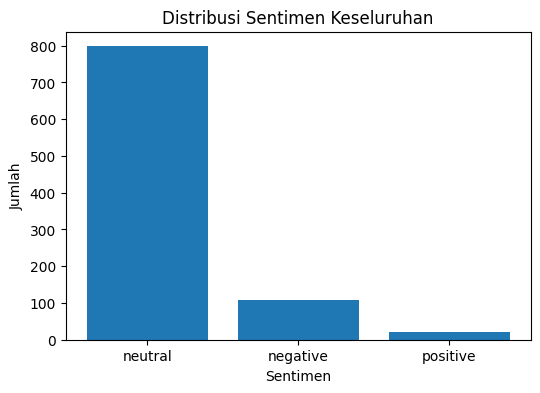

In [ ]:
counts = df["sentiment_label"].value_counts()
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Distribusi Sentimen Keseluruhan")
plt.xlabel("Sentimen"); plt.ylabel("Jumlah")
plt.show()

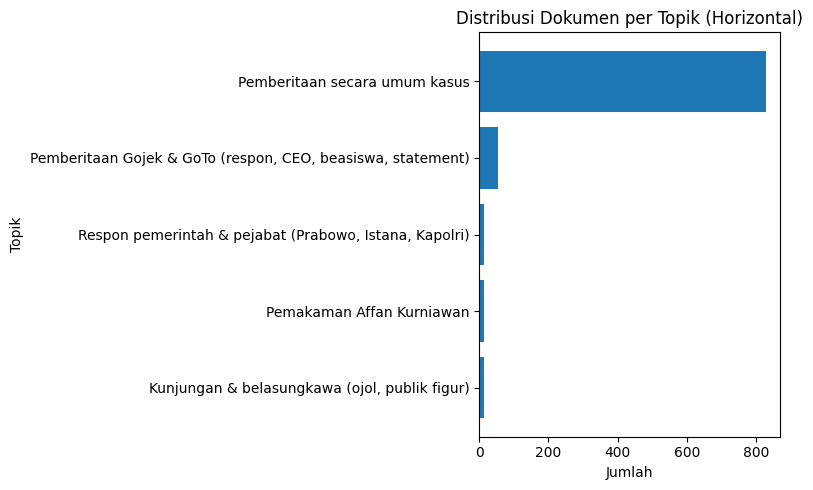

In [ ]:
topic_counts = df["topic_named"].value_counts()

plt.figure(figsize=(8,5))
plt.barh(topic_counts.index, topic_counts.values)
plt.title("Distribusi Dokumen per Topik (Horizontal)")
plt.xlabel("Jumlah")
plt.ylabel("Topik")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


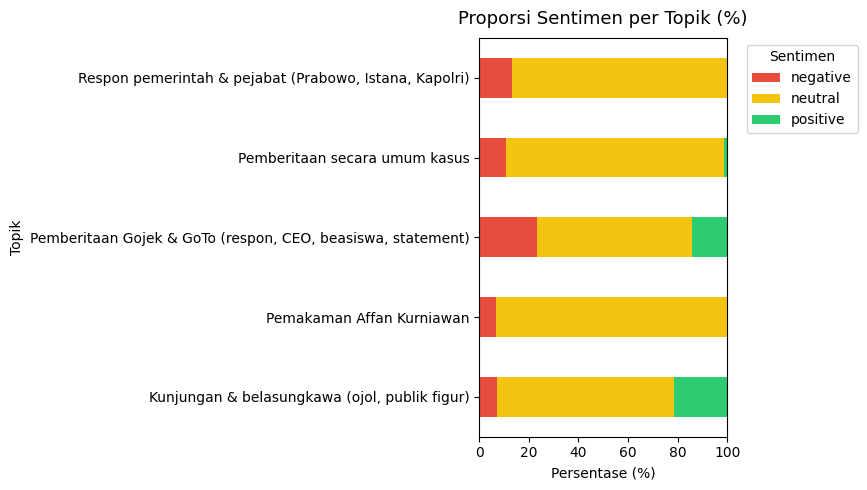

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

prop = pd.crosstab(df["topic_named"], df["sentiment_label"], normalize="index") * 100
prop = prop[["negative", "neutral", "positive"]] if {"negative","neutral","positive"} <= set(prop.columns) else prop

fig, ax = plt.subplots(figsize=(9, 5))
prop.plot(kind="barh", stacked=True, ax=ax, color=["#e74c3c", "#f1c40f", "#2ecc71"])

ax.set_title("Proporsi Sentimen per Topik (%)", fontsize=13, pad=10)
ax.set_xlabel("Persentase (%)")
ax.set_ylabel("Topik")
ax.legend(title="Sentimen", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

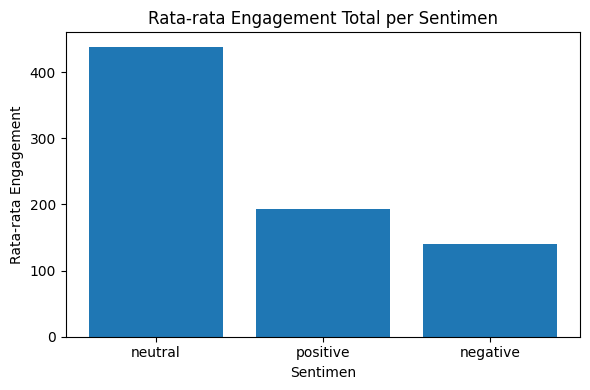

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df_topics.copy()
df["engagement_total"] = df["like_count"].fillna(0) + df["comment_count"].fillna(0)

avg_eng_sent = df.groupby("sentiment_label")["engagement_total"].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
plt.bar(avg_eng_sent.index, avg_eng_sent.values)
plt.title("Rata-rata Engagement Total per Sentimen")
plt.xlabel("Sentimen"); plt.ylabel("Rata-rata Engagement")
plt.tight_layout(); plt.show()

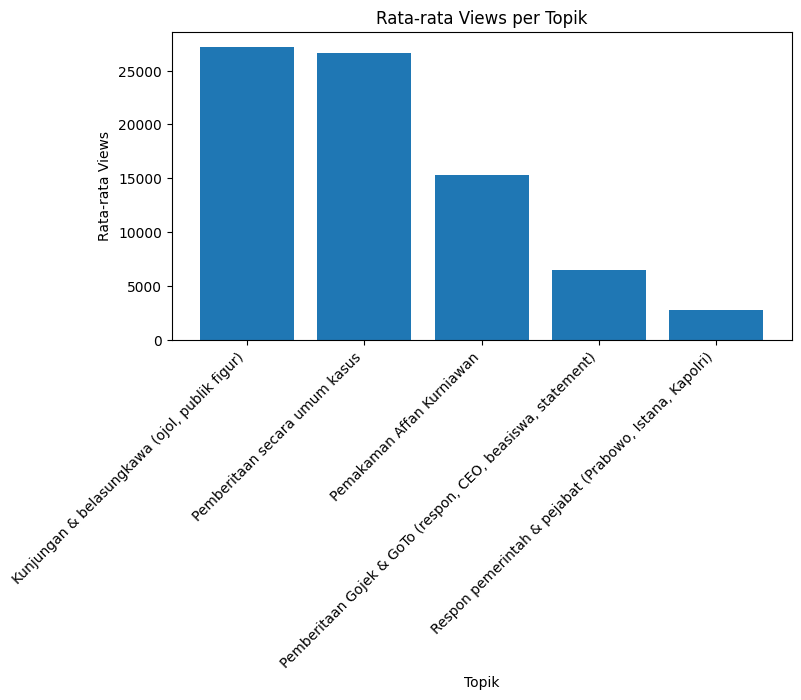

In [ ]:
avg_views_topic = df.groupby("topic_named")["view_count"].mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
plt.bar(avg_views_topic.index, avg_views_topic.values)
plt.title("Rata-rata Views per Topik")
plt.xlabel("Topik"); plt.ylabel("Rata-rata Views"); plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

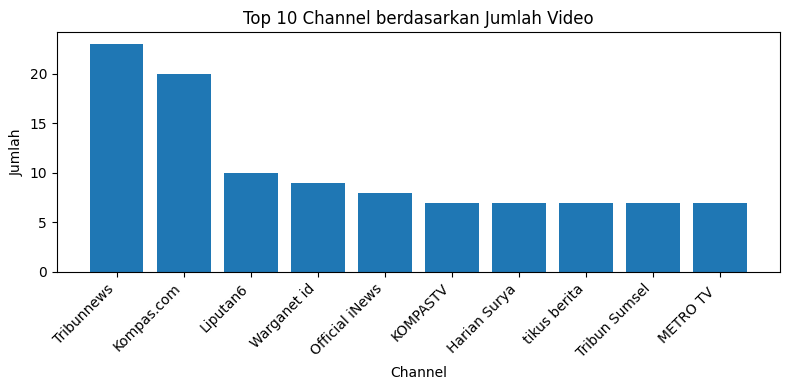

In [ ]:
top_channels = df["channel_title"].value_counts().head(10)
plt.figure(figsize=(8,4))
plt.bar(top_channels.index, top_channels.values)
plt.title("Top 10 Channel berdasarkan Jumlah Video")
plt.xlabel("Channel"); plt.ylabel("Jumlah"); plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

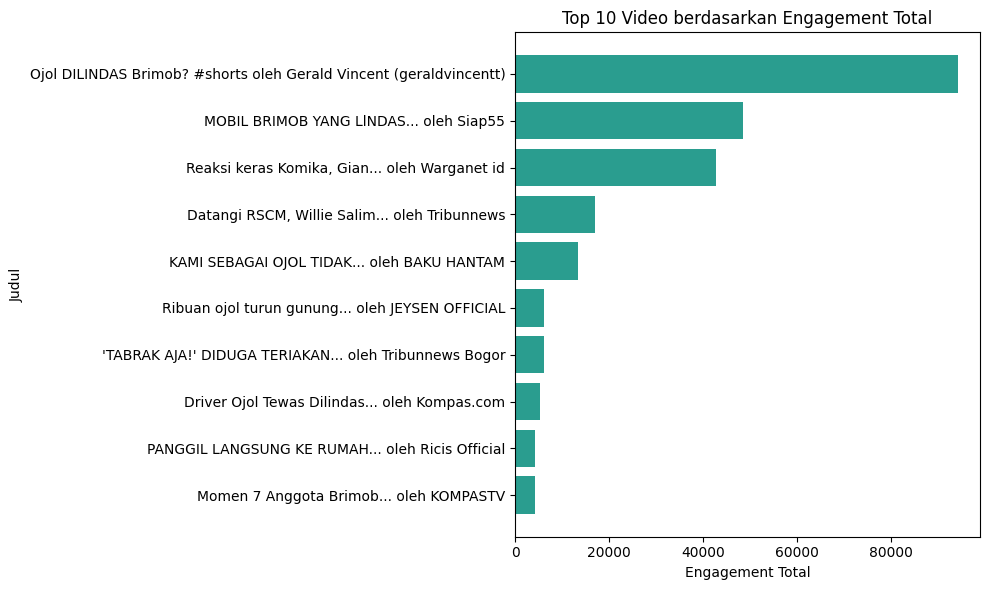

In [ ]:
import matplotlib.pyplot as plt

top_eng = df.sort_values("engagement_total", ascending=False).head(10).iloc[::-1]

def shorten_title(title, channel):
    words = str(title).split()
    short = " ".join(words[:4])
    if len(words) > 4:
        short += "..."
    return f"{short} oleh {channel}"

labels = [shorten_title(t, c) for t, c in zip(top_eng["title"], top_eng["channel_title"])]

plt.figure(figsize=(10,6))
plt.barh(labels, top_eng["engagement_total"], color="#2a9d8f")
plt.title("Top 10 Video berdasarkan Engagement Total")
plt.xlabel("Engagement Total")
plt.ylabel("Judul")
plt.tight_layout()
plt.show()

## Visualisasi Tren

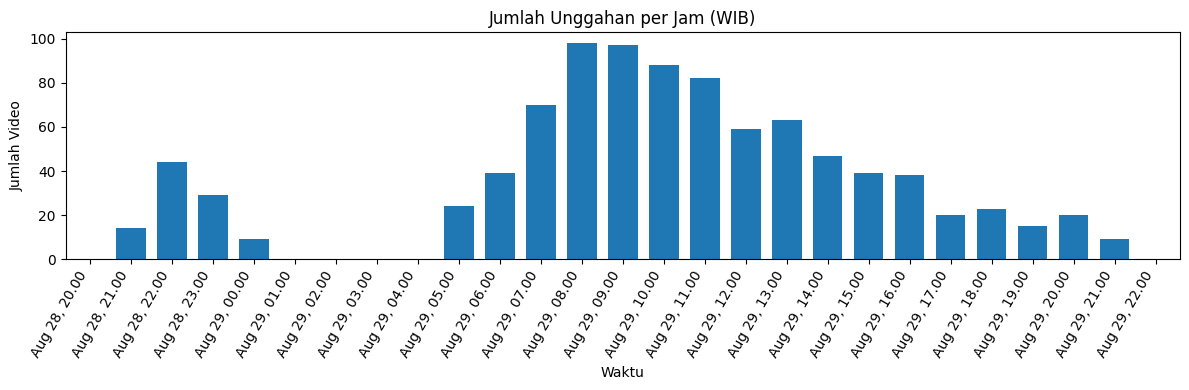

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/main/youtube_search.csv"
df = pd.read_csv(url, encoding="latin1", low_memory=False)

df["published_date_wib"] = df["published_date_wib"].astype(str).str.strip()
df["published_time_wib"] = df["published_time_wib"].astype(str).str.strip()

df["dt_wib"] = pd.to_datetime(
    df["published_date_wib"] + " " + df["published_time_wib"],
    errors="coerce",
    infer_datetime_format=True
)

df = df.dropna(subset=["dt_wib"]).copy()
df["hour_wib"] = df["dt_wib"].dt.floor("H")

per_hour = df.groupby("hour_wib").size().rename("count").sort_index()

plt.figure(figsize=(12,4))
plt.bar(per_hour.index, per_hour.values, width=0.03)  # Lebar batang disesuaikan agar tidak rapat
plt.title("Jumlah Unggahan per Jam (WIB)")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Video")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %H.%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # tampilkan tiap jam
plt.xticks(rotation=60, ha="right")

plt.tight_layout()
plt.show()

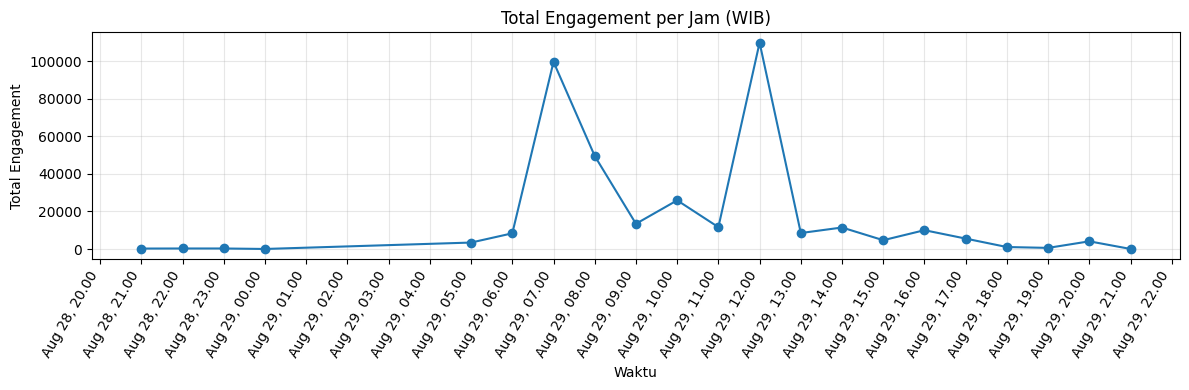

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

df["engagement_total"] = df["like_count"].fillna(0) + df["comment_count"].fillna(0)
per_hour_eng = df.groupby("hour_wib")["engagement_total"].sum()

plt.figure(figsize=(12,4))
plt.plot(per_hour_eng.index, per_hour_eng.values, marker="o", color="#1f77b4")
plt.title("Total Engagement per Jam (WIB)")
plt.xlabel("Waktu"); plt.ylabel("Total Engagement")

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %H.%M"))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.xticks(rotation=60, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analisis Komentar pada Engagement Tertinggi

In [ ]:
import pandas as pd
import re

# Membaca data komentar
url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/refs/heads/main/youtube_top_comment.csv"
df = pd.read_csv(url, encoding="latin1", low_memory=False)

# Samakan struktur dengan sebelumnya: pakai kolom "title" sebagai teks
if "title" not in df.columns:
    candidates = [c for c in ["comment", "comment_text", "text", "content", "body"] if c in df.columns]
    if not candidates:
        raise RuntimeError("Kolom teks komentar tidak ditemukan. Cek nama kolom pada CSV.")
    df["title"] = df[candidates[0]]

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_title"] = df["title"].astype(str).str.lower().apply(clean_text)
df = df.drop_duplicates(subset="clean_title").dropna(subset=["clean_title"])
df = df[df["clean_title"].str.len() > 0]

print("Jumlah data setelah preprocessing:", len(df))
display(df[["title", "clean_title"]].head())

!pip -q install transformers accelerate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

texts = df["title"].astype(str).fillna("").tolist()

model_id = "Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
if getattr(tokenizer, "model_max_length", None) is None or tokenizer.model_max_length > 1e5:
    tokenizer.model_max_length = 512

model = AutoModelForSequenceClassification.from_pretrained(model_id)

clf = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    padding=True,
    max_length=512,
    # device=0,
)

preds = clf(texts, batch_size=32, truncation=True, max_length=512)

out = df.copy()
out["m1_label_raw"] = [p["label"] for p in preds]
out["m1_score"]     = [p["score"] for p in preds]

def norm_label(s):
    s = str(s).strip().lower()
    mapping = {
        "neutral": "neutral",
        "netral": "neutral",
        "positive": "positive",
        "positif": "positive",
        "negative": "negative",
        "negatif": "negative"
    }
    if s not in mapping:
        if "neu" in s: return "neutral"
        if "pos" in s: return "positive"
        if "neg" in s: return "negative"
    return mapping.get(s, s)

out["sentiment_label"] = out["m1_label_raw"].map(norm_label)
out["sentiment_score"] = out["m1_score"]

df_model1 = out.copy()
display(df_model1[["title","sentiment_label","sentiment_score"]].head())

Jumlah data setelah preprocessing: 5927


,title,clean_title
0,Geram gerget marh dna sedih,geram gerget marh dna sedih
1,Hancurkan gedungnya.. hancurkan semuað,hancurkan gedungnya hancurkan semua
2,"7 tersangka pelindas ojol, jadi enaknya mau G3...",tersangka pelindas ojol jadi enaknya mau g a a...
3,"Pusing mau komen apa , biar tuhan yang balas ð¥²",pusing mau komen apa biar tuhan yang balas
4,Info yg gw dapet sih abang ojol ini ga ikut-ik...,info yg gw dapet sih abang ojol ini ga ikut ik...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Device set to use cuda:0


,title,sentiment_label,sentiment_score
0,Geram gerget marh dna sedih,negative,0.998906
1,Hancurkan gedungnya.. hancurkan semuað,negative,0.996705
2,"7 tersangka pelindas ojol, jadi enaknya mau G3...",neutral,0.882750
3,"Pusing mau komen apa , biar tuhan yang balas ð¥²",neutral,0.983267
4,Info yg gw dapet sih abang ojol ini ga ikut-ik...,neutral,0.734047


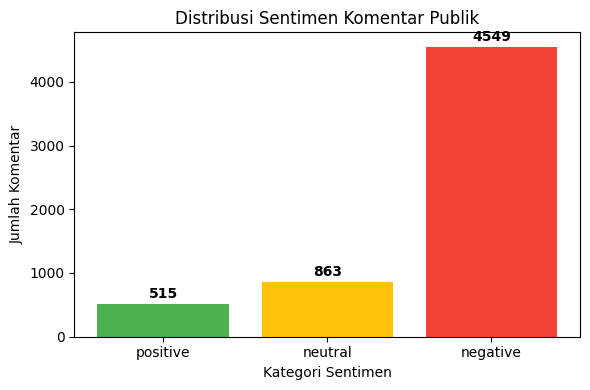

In [ ]:
import matplotlib.pyplot as plt

sent_counts = df_model1["sentiment_label"].value_counts().reindex(["positive", "neutral", "negative"], fill_value=0)

plt.figure(figsize=(6,4))
bars = plt.bar(sent_counts.index, sent_counts.values, color=["#4CAF50","#FFC107","#F44336"])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 50,  # posisi teks
             f"{int(height)}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Distribusi Sentimen Komentar Publik")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

if "df_model1" not in globals():
    raise RuntimeError("Dataframe df_model1 belum ditemukan. Jalankan analisis sentimen terlebih dahulu.")

def tampilkan_contoh(df, label, n=10):
    print(f"\n=== {label.upper()} ===")
    subset = (
        df[df["sentiment_label"] == label]
        .drop_duplicates(subset=["clean_title"])
        .sample(min(n, len(df[df["sentiment_label"] == label])), random_state=42)
    )
    for i, row in enumerate(subset.itertuples(), start=1):
        print(f"{i}. ({row.sentiment_score:.2f}) {row.clean_title}")

for label in ["positive", "neutral", "negative"]:
    tampilkan_contoh(df_model1, label)


=== POSITIVE ===
1. (0.99) pasti bangga
2. (0.86) dari ekspresi nya dapat bet dari bang vincent
3. (0.56) sabar bang gerald saya juga merasakan apa yang abang rasakan bang
4. (1.00) dr ekspresi lu menyampaikan konten ini terima kasih sudah bersimpati terhadap rekan kita sesama rakyat yg tertindas bang gw selalu dukung channel lu bang
5. (0.99) yg gw tunggu acab
6. (0.97) sabar bg kita doakan sodara kita berjuang biar di jauhi marahabaya
7. (1.00) ya alloh bang vincent makasih ude ngewakilin
8. (0.56) lanjut terus ke rumah nya enak bet wfh
9. (0.78) girl dont crywork from home
10. (0.85) percayalah kawan indonesia saat ini sedang tidak baik baik saja ini bukan cuman sekedar untuk revolusi aja karena semua hak hak kita sedang ditindas tetap stay safe buat yang masih demo tetap kondusif dan jaga diri masing masing tujuan kita cuman dan kebencian kita tertuju hanya ke dpr jangan sampai ada provokasi dari pihak luar

=== NEUTRAL ===
1. (0.99) maksudnya malam jum at
2. (0.53) yu yu kita bua

In [ ]:
import re, pandas as pd, numpy as np, emoji, os
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan

pd.set_option("display.max_colwidth", None)

local_path = "/mnt/data/youtube_top_comment.csv"
if os.path.exists(local_path):
    df_src = pd.read_csv(local_path, encoding="latin1", low_memory=False)
else:
    url = "https://raw.githubusercontent.com/bryanreynaldy/Datmin/refs/heads/main/youtube_top_comment.csv"
    df_src = pd.read_csv(url, encoding="latin1", low_memory=False)

text_candidates = [c for c in ["text","comment","comment_text","content","body","title"] if c in df_src.columns]
if not text_candidates:
    raise RuntimeError("Kolom komentar tidak ditemukan (butuh salah satu: text/comment/comment_text/content/body/title).")
df_src = df_src.rename(columns={text_candidates[0]: "text"})

def clean_comment(s: str) -> str:
    s = str(s).lower()
    s = emoji.replace_emoji(s, replace=' ')
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"\\n|\n|\r", " ", s)
    s = re.sub(r"[^a-z0-9#@_\s]", " ", s)  # huruf/angka/hashtag/mention/underscore
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_src["text_clean"] = df_src["text"].astype(str).apply(clean_comment)

wfh_regex = re.compile(
    r"\b(wfh|work\s*from\s*home|kerja\s*(di|)rumah|bekerja\s*(di|)rumah)\b",
    flags=re.IGNORECASE
)
before = len(df_src)
df_src = df_src[~df_src["text_clean"].str.contains(wfh_regex)]
after = len(df_src)

df_src = df_src[df_src["text_clean"].str.len() > 0].drop_duplicates(subset=["text_clean"]).reset_index(drop=True)

print(f"Komentar unik (bersih) : {len(df_src)}")
print(f"Komentar dibuang (WFH) : {before - after}")
display(df_src[["text","text_clean"]].head(10))

stop_id = set(StopWordRemoverFactory().get_stop_words())
stop_extra = {
    "video","channel","subscribe","shorts","shortvideo","fyp","viral","latest",
    "hari","ini","kamu","kita","aja","dong","nih","banget","yang","untuk","dari","dan",
    "di","ke","ada","akan","itu","ini","dengan","para","atau","karena","jadi","saja",
    "bang","kak","bro","sis","om","min","tolong","please","thanks","makasih",
}
stopwords = list(stop_id.union(stop_extra))

vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=stopwords,
    token_pattern=r"(?u)\b[^\d\W]+\b",
    min_df=2
)

embedding_model = SentenceTransformer("indolem/indobertweet-base-uncased")

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric="cosine", random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=8, metric="euclidean",
                                cluster_selection_method="eom", prediction_data=True)

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="indonesian",
    vectorizer_model=vectorizer_model,
    min_topic_size=8,
    nr_topics=7,
    low_memory=True,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=False
)

texts = df_src["text_clean"].tolist()
topics, probs = topic_model.fit_transform(texts)

def safe_max_prob(p):
    if p is None: return np.nan
    if isinstance(p, (list, tuple, np.ndarray)):
        return float(np.max(p)) if len(p) else np.nan
    try: return float(p)
    except: return np.nan

df_topics = df_src.copy()
df_topics["topic"] = topics
df_topics["topic_prob"] = [safe_max_prob(p) for p in probs]

topic_info = topic_model.get_topic_info()
top_terms = {t: [w for w,_ in (topic_model.get_topic(t) or [])[:10]]
             for t in topic_info["Topic"].tolist() if t != -1}

print("Total komentar terpakai:", len(df_topics))
print("Jumlah topik (tanpa -1):", int((topic_info["Topic"] != -1).sum()))
display(topic_info.head(10))

for t in topic_info["Topic"].head(5):
    if t == -1: continue
    print(f"\nTOPIK {t} | {', '.join(top_terms.get(t, [])[:8])}")
    print(df_topics[df_topics["topic"] == t].head(3)[["text_clean"]].to_string(index=False))

Komentar unik (bersih) : 5793
Komentar dibuang (WFH) : 145


,text,text_clean
0,Geram gerget marh dna sedih,geram gerget marh dna sedih
1,Hancurkan gedungnya.. hancurkan semuað,hancurkan gedungnya hancurkan semua
2,"7 tersangka pelindas ojol, jadi enaknya mau G30A atau G30S nihð",7 tersangka pelindas ojol jadi enaknya mau g30a atau g30s nih
3,"Pusing mau komen apa , biar tuhan yang balas ð¥²",pusing mau komen apa biar tuhan yang balas
4,"Info yg gw dapet sih abang ojol ini ga ikut-ikutan demo, dia cuma nganterin orderan makanan tapi naasnya dia jadi korban",info yg gw dapet sih abang ojol ini ga ikut ikutan demo dia cuma nganterin orderan makanan tapi naasnya dia jadi korban
5,Bener nih.. di lindas.. bukan ke lindas.. inget ye DI LINDAS,bener nih di lindas bukan ke lindas inget ye di lindas
6,"Salut gua bang sama elu, di luar sana banyak kanal berita mainstream yang bilang ""TERLINDAS"" BUKAN ""DILINDAS"" seolah-olah itu bukan sebuah kesengajaan. Padahal kita tau semua di video itu sengaja banget",salut gua bang sama elu di luar sana banyak kanal berita mainstream yang bilang terlindas bukan dilindas seolah olah itu bukan sebuah kesengajaan padahal kita tau semua di video itu sengaja banget
7,Aamiin ya rabb,aamiin ya rabb
8,"listyo mundur, polisi asu",listyo mundur polisi asu
9,Sekarang DPR aman pendemo menyasar Kapolres di berbagai kota,sekarang dpr aman pendemo menyasar kapolres di berbagai kota


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Total komentar terpakai: 5793
Jumlah topik (tanpa -1): 6


Topic  Count  \
0     -1   3296   
1      0   2002   
2      1    416   
3      2     29   
4      3     24   
5      4     15   
6      5     11   

                                                                Name  \
0                                               -1_dpr_yg_rakyat_nya   
1                                                0_dpr_yg_nya_rakyat   
2                                       1_dewan_rakyat_dpr_dpr dewan   
3                                2_wa_innalillahi_ilaihi_ilaihi raji   
4                                            3_rakyat_yg_orang_kalau   
5                                        4_fight_amiin_amiinn_amiiin   
6  5_revolusi_revolusi revolusi_revolusi reformasi_revolusi perancis   

                                                                                                                                                   Representation  \
0                                                                                                        [dpr, yg, rakyat, nya, sama, gak, udah, ga, demo, semua]   
1                                                                                                  [dpr, yg, nya, rakyat, gerald, tahun, ulang, gak, demo, rumah]   
2                                            [dewan, rakyat, dpr, dpr dewan, perwakilan, dewan perwakilan, perwakilan rakyat, rakyat dpr, rakyat dewan, penyiksa]   
3                                                                                [wa, innalillahi, ilaihi, ilaihi raji, raji un, raji, inna, aamiin, un, wa inna]   
4                                                                                            [rakyat, yg, orang, kalau, dpr, malah, mau, bilang, indonesia, demo]   
5                                                                                       [fight, amiin, amiinn, amiiin, najis, mantap, jokowi, rip, aamiin, hidup]   
6  [revolusi, revolusi revolusi, revolusi reformasi, revolusi perancis, revolusiindonesia, indonesia revolusi, revolusi indonesia, perancis, darurat, jawabannya]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


TOPIK 0 | dpr, yg, nya, rakyat, gerald, tahun, ulang, gak
                                                                                                             text_clean
info yg gw dapet sih abang ojol ini ga ikut ikutan demo dia cuma nganterin orderan makanan tapi naasnya dia jadi korban
                                                                                                             ke bandara
                                          emosinya jangan di tahan tahan bang keluarin aja sama ko kita sama sama emosi

TOPIK 1 | dewan, rakyat, dpr, dpr dewan, perwakilan, dewan perwakilan, perwakilan rakyat, rakyat dpr
                                                   text_clean
                                     listyo mundur polisi asu
                                     d derita p para r rakyat
dewan perwakilan rampok bang mana ada dewan perwakilan rakyat

TOPIK 2 | wa, innalillahi, ilaihi, ilaihi raji, raji un, raji, inna, aamiin
                                  

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

if "df_topics" not in globals():
    raise RuntimeError("df_topics tidak ditemukan. Jalankan blok sebelumnya yang menghasilkan df_topics.")

text_col = "text_clean" if "text_clean" in df_topics.columns else ("text" if "text" in df_topics.columns else None)
if text_col is None:
    raise RuntimeError("Kolom teks tidak ditemukan di df_topics. Butuh 'text_clean' atau 'text'.")

merge_map = {
    -1: "Kritik Institusi (DPR/Polri/Brimob)",
     0: "Kritik Institusi (DPR/Polri/Brimob)",
     1: "Kritik Institusi (DPR/Polri/Brimob)",
     2: "Dukacita & Doa",
     3: "Dukacita & Doa",
     4: "Seruan Aksi/Perubahan",
     5: "Seruan Aksi/Perubahan",
}
df_final = df_topics.copy()
df_final["cluster_final"] = df_final["topic"].map(merge_map).fillna("Lainnya")

summary = (df_final
           .groupby("cluster_final")
           .size()
           .reset_index(name="count")
           .sort_values("count", ascending=False)
           .reset_index(drop=True))
print("Ringkasan klaster (manual merge):")
display(summary)

stop_basic = set([
    "video","channel","subscribe","shorts","shortvideo","fyp","viral","latest",
    "hari","ini","kamu","kita","aja","dong","nih","banget","yang","untuk","dari","dan",
    "di","ke","ada","akan","itu","ini","dengan","para","atau","karena","jadi","saja",
    "bang","kak","bro","sis","om","min","tolong","please","thanks","makasih",
    "ya","iya","ga","gak","udah","sama","nya","deh","lah","loh","kok","dong","kan","yg"
])

def top_terms_for_subset(series_text, topn=10):
    vec = CountVectorizer(
        ngram_range=(1,2),
        token_pattern=r"(?u)\b[^\d\W]+\b",
        stop_words=list(stop_basic),
        min_df=2
    )
    try:
        X = vec.fit_transform(series_text.dropna().astype(str))
        sums = np.asarray(X.sum(axis=0)).ravel()
        vocab = np.array(vec.get_feature_names_out())
        order = np.argsort(-sums)
        return [f"{vocab[i]} ({int(sums[i])})" for i in order[:topn]]
    except ValueError:
        return []

keywords = {}
for cname in summary["cluster_final"]:
    subset = df_final.loc[df_final["cluster_final"] == cname, text_col]
    keywords[cname] = top_terms_for_subset(subset, topn=10)

print("\nKata kunci per klaster (frekuensi sederhana):")
for cname, terms in keywords.items():
    print(f"- {cname}: {', '.join(terms) if terms else '(tidak ada)'}")

rep_samples = {}
has_prob = "topic_prob" in df_final.columns
for cname in summary["cluster_final"]:
    sub = df_final[df_final["cluster_final"] == cname]
    if has_prob:
        sub = sub.sort_values("topic_prob", ascending=False)
    rep = sub[text_col].head(20).tolist()
    rep_samples[cname] = rep

print("\nContoh komentar representatif per klaster (maks 5):")
for cname, rows in rep_samples.items():
    print(f"\n=== {cname} ===")
    for i, r in enumerate(rows, 1):
        print(f"{i}. {r}")

Ringkasan klaster (manual merge):


,cluster_final,count
0,Kritik Institusi (DPR/Polri/Brimob),5714
1,Dukacita & Doa,53
2,Seruan Aksi/Perubahan,26



Kata kunci per klaster (frekuensi sederhana):
- Kritik Institusi (DPR/Polri/Brimob): dpr (1620), rakyat (1063), mereka (620), bisa (485), demo (485), indonesia (417), semua (397), mau (396), polisi (366), negara (364)
- Dukacita & Doa: dpr (64), rakyat (59), orang (38), bisa (38), mereka (36), kalau (33), malah (33), demo (32), indonesia (31), mau (31)
- Seruan Aksi/Perubahan: revolusi (12), revolusi revolusi (3)

Contoh komentar representatif per klaster (maks 5):

=== Kritik Institusi (DPR/Polri/Brimob) ===
1. info yg gw dapet sih abang ojol ini ga ikut ikutan demo dia cuma nganterin orderan makanan tapi naasnya dia jadi korban
2. semoga negeri ini bisa sembuh dari semua kebusukan ini
3. tul
4. ke bandara
5. kayaknya pemerintah udah bener bener gak punya hati
6. hidup cuma sekali kenapa saya wni
7. abangnya emosi banget
8. @@dikozulmi6613dirumah para dpr aja
9. guna dpr apaan
10. tadi gue lihat komen yang masuk akal dimana kita jangan demo depan dpr mpr melainkan demo di bandara int

# Visualisasi untuk Komentar

Jumlah data setelah merge: 5793
                         cluster_final sentiment_label
0  Kritik Institusi (DPR/Polri/Brimob)        negative
1  Kritik Institusi (DPR/Polri/Brimob)        negative
2  Kritik Institusi (DPR/Polri/Brimob)             NaN
3  Kritik Institusi (DPR/Polri/Brimob)         neutral
4  Kritik Institusi (DPR/Polri/Brimob)         neutral


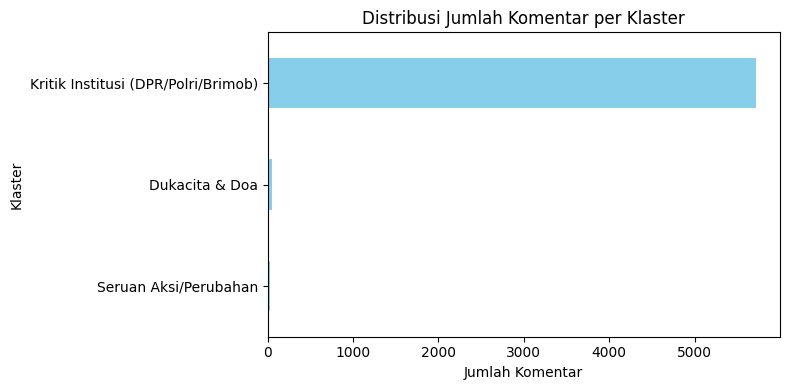

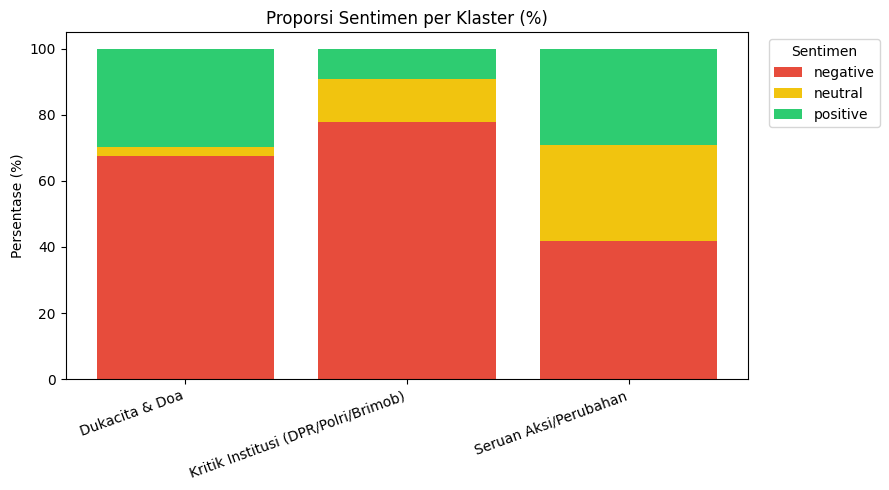

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if "df_model1" not in globals():
    raise RuntimeError("Data sentimen (df_model1) belum tersedia.")
if "df_final" not in globals():
    raise RuntimeError("Data topik komentar (df_final) belum tersedia.")

# Normalisasi nama kolom teks agar sama
df_sent = df_model1.rename(columns={"clean_title": "text_clean"})[
    ["text_clean", "sentiment_label", "sentiment_score"]
]

# Merge berdasarkan teks komentar yang sudah dibersihkan
df_final = df_final.merge(df_sent, on="text_clean", how="left")

print(f"Jumlah data setelah merge: {len(df_final)}")
print(df_final[["cluster_final", "sentiment_label"]].head())

# --- 2) Plot Distribusi Jumlah Komentar per Klaster ---
counts = df_final["cluster_final"].value_counts()

plt.figure(figsize=(8, 4))
counts.plot(kind="barh", color="skyblue")
plt.title("Distribusi Jumlah Komentar per Klaster")
plt.xlabel("Jumlah Komentar")
plt.ylabel("Klaster")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- 3) Plot Proporsi Sentimen per Klaster (Stacked Bar %) ---
# Pivot klaster x sentimen
sent_pivot = (
    df_final.groupby(["cluster_final", "sentiment_label"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

row_sums = sent_pivot.sum(axis=1).replace(0, np.nan)
sent_pct = sent_pivot.div(row_sums, axis=0) * 100

# Plot stacked bar
plt.figure(figsize=(9, 5))
bottom = np.zeros(len(sent_pct))
x = np.arange(len(sent_pct))
labels = list(sent_pct.columns)
colors = {"positive": "#2ecc71", "neutral": "#f1c40f", "negative": "#e74c3c"}

for col in labels:
    vals = sent_pct[col].values
    plt.bar(x, vals, bottom=bottom, label=col, color=colors.get(col, None))
    bottom += vals

plt.title("Proporsi Sentimen per Klaster (%)")
plt.xticks(x, sent_pct.index, rotation=20, ha="right")
plt.ylabel("Persentase (%)")
plt.legend(title="Sentimen", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()